In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-satisfaction-in-airline/Invistico_Airline.csv


**Part IV**

In the last and final part of the Invistico Airlines analysis, I will be creating the final model, an XGBoost model.

**Score Comparison**

1. **Binomial Logistic Regresison**- 80.2% accuracy

2. **Tuned Decision Tree**- 94.1% accuracy

3. **Tuned Random Forest**- 94.2% accuracy

In [2]:
# Import all necessary libraries and packages
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load in the dataset
invistico= pd.read_csv('/kaggle/input/customer-satisfaction-in-airline/Invistico_Airline.csv')

In [4]:
# View data
invistico.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


In [5]:
# View data types
invistico.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

In [6]:
# Convert categorical featues to numerical
invistico= pd.get_dummies(invistico, columns=['satisfaction', 'Customer Type', 'Type of Travel', 'Class'])

In [7]:
# Define variable for model
y= invistico['satisfaction_satisfied']
X= invistico.copy()
X= X.drop(['satisfaction_satisfied', 'satisfaction_dissatisfied'], axis=1)


In [8]:
# Train and test data
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, random_state= 0)

In [9]:
# Define XGB objective
xgb= XGBClassifier(objective= 'binary:logistic', random_state= 0)

In [10]:
# XGB Parameters and scoring
cv_params= {'max_depth': [4,6],
            'min_child_weight': [3,5],
            'learning_rate': [0.1,0.2,0.3],
            'n_estimators': [5,10,15],
            'subsample': [0.7],
            'colsample_bytree': [0.7]
           }

scoring= {'accuracy', 'precision', 'recall', 'f1'}

In [11]:
# Gridsearch
xgb_cv= GridSearchCV(xgb, cv_params, cv= 5, refit= 'f1')

In [12]:
%%time
# Fit model to training data
xgb_cv.fit(X_train, y_train)

CPU times: user 3min 56s, sys: 634 ms, total: 3min 56s
Wall time: 1min 44s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1')

In [13]:
# Predict test data
y_pred= xgb_cv.predict(X_test)

In [14]:
# View scores
ac_score= metrics.accuracy_score(y_test, y_pred)
print('Accuracy score: ', ac_score)

pc_score= metrics.precision_score(y_test, y_pred)
print('Precision score: ', pc_score)

rc_score= metrics.recall_score(y_test, y_pred)
print('Recall score: ', rc_score)

f1_score= metrics.f1_score(y_test, y_pred)
print('F1 score: ', f1_score)

Accuracy score:  0.93717277486911
Precision score:  0.9477231536021749
Recall score:  0.9374229691876751
F1 score:  0.9425449219850165


**XGBoost Scores**

It's important to remember that in classification problems, accuracy is useful to know but may not be the best metric to evaluate this model. 

Precision and recall scores are both useful to evaluate the correct predictive capability of the model because they balance the false positives and false negatives inherent in prediction. The model shows a precision score of 0.948, suggesting the model is very good at predicting true positives. This means the model correctly predicts whether an airline passenger will be satisfied. The recall score of 0.940 is also very good. This means that the model does a good job of correctly identifying dissatisfied passengers within the dataset. These two metrics combined give a better assessment of model performance than the accuracy metric does alone.

The F1 score balances the precision and recall performance to give a combined assessment of how well this model delivers predictions. In this case, the F1 score is 0.944, which suggests very strong predictive power in this model.

Now, I will gain clarity with a confusion matrix, which isa graphic that shows a model's true and false positives and true and false negatives. It helps to create a visual representation of the components feeding into the metrics above.  

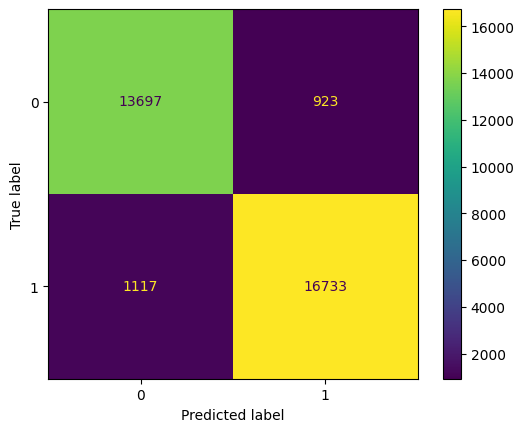

In [15]:
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= xgb_cv.classes_)
disp.plot()

**Confusion Matrix**

The top left to bottom right diagonal in the confusion matrix represents the correct predictions,and the ratio of these squares showcases the accuracy.

Additionally, the concentration of true positives and true negatives stands out relative to false positives and false negatives, respectively.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

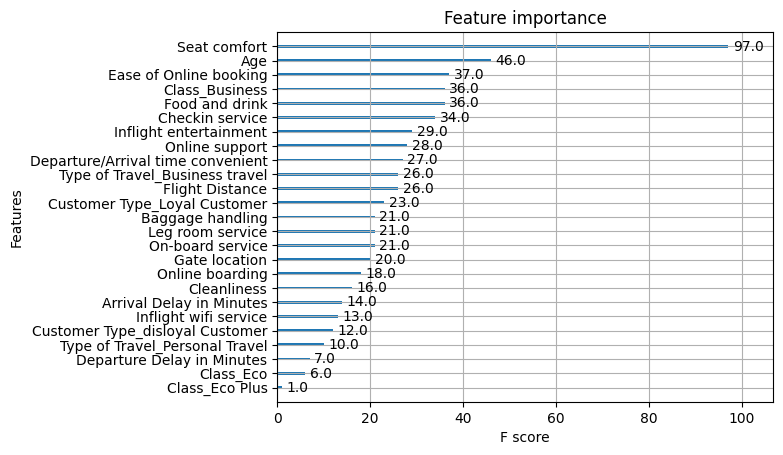

In [16]:
# Feature Importance
plot_importance(xgb_cv.best_estimator_)

**Feature Importance**

By a wide margin, 'seat comfort' rated as most important in the model.The type of seating is very different between first class and coach seating. However, the perks of being in first class also go beyond the seating type, so perhaps that is an underlying explanation of this feature’s importance.

Surprisingly, delays (both arrival and departure) and inflight entertainment did not score as highly important in this model.

In [17]:
# Compare all models
table= pd.DataFrame({'Model': ['Binomial Logistic Regression', 'Tuned Decision Tree', 'Tuned Random Forest', 'Tuned XGBoost'],
         'Accuracy': [0.801529, 0.940864, 0.942450, ac_score],
         'Precision': [0.816142, 0.955197, 0.950128, pc_score],
         'Recall': [0.821530, 0.935863, 0.944501, rc_score],
         'F1 Score': [0.818827, 0.945422, 0.947306, f1_score]
        })
table

,Model,Accuracy,Precision,Recall,F1 Score
0,Binomial Logistic Regression,0.801529,0.816142,0.821530,0.818827
1,Tuned Decision Tree,0.940864,0.955197,0.935863,0.945422
2,Tuned Random Forest,0.942450,0.950128,0.944501,0.947306
3,Tuned XGBoost,0.937173,0.947723,0.937423,0.942545


**Model Evaluation**

The Binomial Logistic Regression model achieved decent but unexceptional metrics, with an accuracy of 80.1%, precision of 81.6%, recall of 82.1% and an F1 score of 81.8%. 

The Tuned Decision Tree model performed significantly better across all metrics, attaining an accuracy of 94.1%, precision of 95.5%, recall of 93.5%, and an F1 score of 94.5%. This suggests that the decision tree algorithm was able to effectively learn the complex patterns relating customer data to satisfaction levels.

The Tuned Random Forest model edged out the decision tree slightly, achieving the highest overall metrics with an accuracy of 94.5%, precision of 95%, recall of 94.5% and an F1 score of 94.7%. The random forest's ensemble approach allowed it to capture additional signal compared to a single decision tree.

However, the Tuned XGBoost model also performed very competitively, with an accuracy of 93.7%, precision of 94.8%, recall of 93.7%, and an F1 score of 94.%. 

**Champion Model**

While the Tuned XGBoost model also performed very well, the marginal improvements of the Tuned Random Forest combined with its robustness and relative interpretability make it a strong overall choice as the champion model.

**Stakeholder Recommendations**

I recommend adopting the Tuned Random Forest model as the production model for predicting customer satisfaction. This model achieved the highest overall metrics.

It will be critical to implement a process for continuous monitoring and retraining of the model, as customer preferences can shift over time. I suggest retraining the random forest on new data at regular intervals, such as quarterly, and monitoring performance metrics like accuracy to detect any degradation requiring action.

Analyzing the feature importances and relations can yield valuable insights - identify the top factors correlated with satisfaction/dissatisfaction, explore interactions between features, and share these findings with operations teams to improve service areas tied to customer pain points.

Additionally, I recommend exploring an ensemble model combining the random forest and the strong-performing Tuned XGBoost model, which could further boost predictive performance. 

Finally, it is important to consider the ethical implications around data bias, model interpretability, and discrimination. Ensure the underlying data is unbiased, that model decisions can be properly explained to customers, and implement processes to assess for unfair treatment of protected groups. By responsibly leveraging this powerful predictive model, Invistico Airlines can drive substantial improvements in customer experience, retention rates, and long-term loyalty.
